In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random

# our classes
from agentLFA import AgentLFA, SARSALambdaAgentLFA
from environment import Environment
from screen import Screen

pygame 2.0.1 (SDL 2.0.14, Python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


Configurações gerais para a execução dos modelos:

* O espaço de ações é denifido como uma matriz identidade 3x3
* Há três ações possíveis (continuar na mesma direção, virar para a esquerda, virar para a direita)
* Como cada estado é representado por um vetor binário de 11 posições, ao todo há 2^11 estados possíveis

In [2]:
# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

In [3]:
# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

In [4]:
def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)


def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action


A função de recompensa padrão é definida como:
    
* Ganha 10 pontos por comer a maçã
* Perde 10 pontos por morrer
* Recompensa 0 caso contrário

In [5]:
def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

# SARSA

Seguiremos os mesmos experimentos realizados com o Q-Learning, de modo a verificarmos a diferença nos resultados variando apenas o agente.

In [6]:
def run_sarsa(agent: SARSALambdaAgentLFA, reward_function, episodes, display, speed, verbose=True):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}
    start = time.time()
    while episode < episodes:
        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
                    
            screen.display()
        agent.reset_E()
        state1, done = env.reset()
        #state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            #state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            decoded_action1 = decode_action(action1)
            decoded_action2 = decode_action(action2)
            q_new = agent.state_value_function(state2, decoded_action2)
            target = reward + agent.gamma * q_new
            agent.update(target, state1, decoded_action1)
            agent.E[decode_state(state1), decoded_action1] = agent.gamma * agent.lambda_value * agent.E[decode_state(state1), decoded_action1]

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)
            
            end = time.time()
            diff = end - start
            if diff > 60: # 1min
                break

        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)
        
        end = time.time()
        diff = end - start
        if diff > 60: # 1min
            break
        

    return metrics

In [7]:
def run_experiment(n, g, l):
    # define agent
    sarsaAgent = SARSALambdaAgentLFA(n, g, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)
    sarsaAgent.lambda_value = l

    start = time.time()
    metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
    end = time.time()

    plot_metrics(metrics, filepath=f'SarsaLambda_LFA_{N0}_{gamma}_{str(Lambda).replace(".","")}.png')

    print('Run time:', (end-start), 'seconds')
    print('Max. Score:', max(metrics['scores']))
    print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 1
Game 4      Score: 2
Game 5      Score: 2
Game 6      Score: 2
Game 7      Score: 3
Game 8      Score: 3
Game 9      Score: 1
Game 10      Score: 6
Game 11      Score: 2
Game 12      Score: 2
Game 13      Score: 6
Game 14      Score: 1
Game 15      Score: 4
Game 16      Score: 1
Game 17      Score: 3
Game 18      Score: 2
Game 19      Score: 4
Game 20      Score: 3
Game 21      Score: 7
Game 22      Score: 4
Game 23      Score: 2
Game 24      Score: 4
Game 25      Score: 3
Game 26      Score: 2
Game 27      Score: 4
Game 28      Score: 1
Game 29      Score: 3
Game 30      Score: 3
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 2
Game 38      Score: 5
Game 39      Score: 1
Game 40      Score: 1
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 3
Game 44      Score: 1
Game 45      Score: 1
Game 46      Score:

Game 362      Score: 4
Game 363      Score: 1
Game 364      Score: 1
Game 365      Score: 2
Game 366      Score: 4
Game 367      Score: 3
Game 368      Score: 3
Game 369      Score: 6
Game 370      Score: 0
Game 371      Score: 1
Game 372      Score: 1
Game 373      Score: 1
Game 374      Score: 2
Game 375      Score: 3
Game 376      Score: 3
Game 377      Score: 3
Game 378      Score: 6
Game 379      Score: 2
Game 380      Score: 2
Game 381      Score: 4
Game 382      Score: 6
Game 383      Score: 6
Game 384      Score: 2
Game 385      Score: 2
Game 386      Score: 3
Game 387      Score: 4
Game 388      Score: 4
Game 389      Score: 2
Game 390      Score: 3
Game 391      Score: 1
Game 392      Score: 2
Game 393      Score: 6
Game 394      Score: 4
Game 395      Score: 3
Game 396      Score: 2
Game 397      Score: 6
Game 398      Score: 3
Game 399      Score: 1
Game 400      Score: 1
Game 401      Score: 1
Game 402      Score: 1
Game 403      Score: 3
Game 404      Score: 2
Game 405   

Game 723      Score: 1
Game 724      Score: 1
Game 725      Score: 2
Game 726      Score: 2
Game 727      Score: 5
Game 728      Score: 4
Game 729      Score: 1
Game 730      Score: 1
Game 731      Score: 2
Game 732      Score: 1
Game 733      Score: 2
Game 734      Score: 0
Game 735      Score: 2
Game 736      Score: 2
Game 737      Score: 0
Game 738      Score: 1
Game 739      Score: 2
Game 740      Score: 1
Game 741      Score: 1
Game 742      Score: 3
Game 743      Score: 2
Game 744      Score: 2
Game 745      Score: 1
Game 746      Score: 1
Game 747      Score: 1
Game 748      Score: 0
Game 749      Score: 3
Game 750      Score: 2
Game 751      Score: 2
Game 752      Score: 1
Game 753      Score: 2
Game 754      Score: 3
Game 755      Score: 1
Game 756      Score: 6
Game 757      Score: 1
Game 758      Score: 3
Game 759      Score: 1
Game 760      Score: 0
Game 761      Score: 4
Game 762      Score: 1
Game 763      Score: 2
Game 764      Score: 6
Game 765      Score: 2
Game 766   

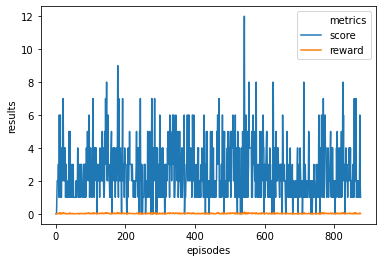

In [27]:
N0 = 1
gamma = 1
Lambda = 0
run_experiment(N0, gamma, Lambda)

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 1
Game 4      Score: 2
Game 5      Score: 2
Game 6      Score: 2
Game 7      Score: 3
Game 8      Score: 3
Game 9      Score: 1
Game 10      Score: 6
Game 11      Score: 2
Game 12      Score: 2
Game 13      Score: 6
Game 14      Score: 1
Game 15      Score: 4
Game 16      Score: 1
Game 17      Score: 3
Game 18      Score: 2
Game 19      Score: 4
Game 20      Score: 3
Game 21      Score: 7
Game 22      Score: 4
Game 23      Score: 2
Game 24      Score: 4
Game 25      Score: 3
Game 26      Score: 2
Game 27      Score: 4
Game 28      Score: 1
Game 29      Score: 3
Game 30      Score: 3
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 2
Game 38      Score: 5
Game 39      Score: 1
Game 40      Score: 1
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 3
Game 44      Score: 1
Game 45      Score: 1
Game 46      Score:

Game 362      Score: 4
Game 363      Score: 1
Game 364      Score: 1
Game 365      Score: 2
Game 366      Score: 4
Game 367      Score: 3
Game 368      Score: 3
Game 369      Score: 6
Game 370      Score: 0
Game 371      Score: 1
Game 372      Score: 1
Game 373      Score: 1
Game 374      Score: 2
Game 375      Score: 3
Game 376      Score: 3
Game 377      Score: 3
Game 378      Score: 6
Game 379      Score: 2
Game 380      Score: 2
Game 381      Score: 4
Game 382      Score: 6
Game 383      Score: 6
Game 384      Score: 2
Game 385      Score: 2
Game 386      Score: 3
Game 387      Score: 4
Game 388      Score: 4
Game 389      Score: 2
Game 390      Score: 3
Game 391      Score: 1
Game 392      Score: 2
Game 393      Score: 6
Game 394      Score: 4
Game 395      Score: 3
Game 396      Score: 2
Game 397      Score: 6
Game 398      Score: 3
Game 399      Score: 1
Game 400      Score: 1
Game 401      Score: 1
Game 402      Score: 1
Game 403      Score: 3
Game 404      Score: 2
Game 405   

Game 727      Score: 5
Game 728      Score: 4
Game 729      Score: 1
Game 730      Score: 1
Game 731      Score: 2
Game 732      Score: 1
Game 733      Score: 2
Game 734      Score: 0
Game 735      Score: 2
Game 736      Score: 2
Game 737      Score: 0
Game 738      Score: 1
Game 739      Score: 2
Game 740      Score: 1
Game 741      Score: 1
Game 742      Score: 3
Game 743      Score: 2
Game 744      Score: 2
Game 745      Score: 1
Game 746      Score: 1
Game 747      Score: 1
Game 748      Score: 0
Game 749      Score: 3
Game 750      Score: 2
Game 751      Score: 2
Game 752      Score: 1
Game 753      Score: 2
Game 754      Score: 3
Game 755      Score: 1
Game 756      Score: 6
Game 757      Score: 1
Game 758      Score: 3
Game 759      Score: 1
Game 760      Score: 0
Game 761      Score: 4
Game 762      Score: 1
Game 763      Score: 2
Game 764      Score: 6
Game 765      Score: 2
Game 766      Score: 4
Game 767      Score: 3
Game 768      Score: 1
Game 769      Score: 7
Game 770   

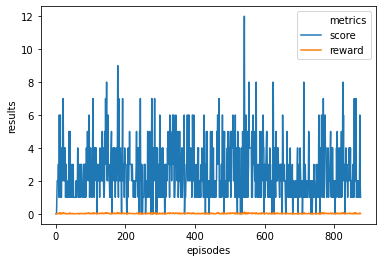

In [26]:
N0 = 1
gamma = 1
Lambda = 0.2
run_experiment(N0, gamma, Lambda)

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 1
Game 4      Score: 2
Game 5      Score: 2
Game 6      Score: 2
Game 7      Score: 3
Game 8      Score: 3
Game 9      Score: 1
Game 10      Score: 6
Game 11      Score: 2
Game 12      Score: 2
Game 13      Score: 6
Game 14      Score: 1
Game 15      Score: 4
Game 16      Score: 1
Game 17      Score: 3
Game 18      Score: 2
Game 19      Score: 4
Game 20      Score: 3
Game 21      Score: 7
Game 22      Score: 4
Game 23      Score: 2
Game 24      Score: 4
Game 25      Score: 3
Game 26      Score: 2
Game 27      Score: 4
Game 28      Score: 1
Game 29      Score: 3
Game 30      Score: 3
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 2
Game 38      Score: 5
Game 39      Score: 1
Game 40      Score: 1
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 3
Game 44      Score: 1
Game 45      Score: 1
Game 46      Score:

Game 368      Score: 3
Game 369      Score: 6
Game 370      Score: 0
Game 371      Score: 1
Game 372      Score: 1
Game 373      Score: 1
Game 374      Score: 2
Game 375      Score: 3
Game 376      Score: 3
Game 377      Score: 3
Game 378      Score: 6
Game 379      Score: 2
Game 380      Score: 2
Game 381      Score: 4
Game 382      Score: 6
Game 383      Score: 6
Game 384      Score: 2
Game 385      Score: 2
Game 386      Score: 3
Game 387      Score: 4
Game 388      Score: 4
Game 389      Score: 2
Game 390      Score: 3
Game 391      Score: 1
Game 392      Score: 2
Game 393      Score: 6
Game 394      Score: 4
Game 395      Score: 3
Game 396      Score: 2
Game 397      Score: 6
Game 398      Score: 3
Game 399      Score: 1
Game 400      Score: 1
Game 401      Score: 1
Game 402      Score: 1
Game 403      Score: 3
Game 404      Score: 2
Game 405      Score: 2
Game 406      Score: 1
Game 407      Score: 1
Game 408      Score: 4
Game 409      Score: 3
Game 410      Score: 4
Game 411   

Game 731      Score: 2
Game 732      Score: 1
Game 733      Score: 2
Game 734      Score: 0
Game 735      Score: 2
Game 736      Score: 2
Game 737      Score: 0
Game 738      Score: 1
Game 739      Score: 2
Game 740      Score: 1
Game 741      Score: 1
Game 742      Score: 3
Game 743      Score: 2
Game 744      Score: 2
Game 745      Score: 1
Game 746      Score: 1
Game 747      Score: 1
Game 748      Score: 0
Game 749      Score: 3
Game 750      Score: 2
Game 751      Score: 2
Game 752      Score: 1
Game 753      Score: 2
Game 754      Score: 3
Game 755      Score: 1
Game 756      Score: 6
Game 757      Score: 1
Game 758      Score: 3
Game 759      Score: 1
Game 760      Score: 0
Game 761      Score: 4
Game 762      Score: 1
Game 763      Score: 2
Game 764      Score: 6
Game 765      Score: 2
Game 766      Score: 4
Game 767      Score: 3
Game 768      Score: 1
Game 769      Score: 7
Game 770      Score: 4
Game 771      Score: 1
Game 772      Score: 1
Game 773      Score: 5
Game 774   

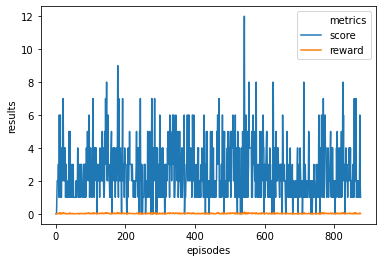

In [25]:
N0 = 1
gamma = 1
Lambda = 0.5
run_experiment(N0, gamma, Lambda)

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 1
Game 4      Score: 2
Game 5      Score: 2
Game 6      Score: 2
Game 7      Score: 3
Game 8      Score: 3
Game 9      Score: 1
Game 10      Score: 6
Game 11      Score: 2
Game 12      Score: 2
Game 13      Score: 6
Game 14      Score: 1
Game 15      Score: 4
Game 16      Score: 1
Game 17      Score: 3
Game 18      Score: 2
Game 19      Score: 4
Game 20      Score: 3
Game 21      Score: 7
Game 22      Score: 4
Game 23      Score: 2
Game 24      Score: 4
Game 25      Score: 3
Game 26      Score: 2
Game 27      Score: 4
Game 28      Score: 1
Game 29      Score: 3
Game 30      Score: 3
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 2
Game 38      Score: 5
Game 39      Score: 1
Game 40      Score: 1
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 3
Game 44      Score: 1
Game 45      Score: 1
Game 46      Score:

Game 362      Score: 4
Game 363      Score: 1
Game 364      Score: 1
Game 365      Score: 2
Game 366      Score: 4
Game 367      Score: 3
Game 368      Score: 3
Game 369      Score: 6
Game 370      Score: 0
Game 371      Score: 1
Game 372      Score: 1
Game 373      Score: 1
Game 374      Score: 2
Game 375      Score: 3
Game 376      Score: 3
Game 377      Score: 3
Game 378      Score: 6
Game 379      Score: 2
Game 380      Score: 2
Game 381      Score: 4
Game 382      Score: 6
Game 383      Score: 6
Game 384      Score: 2
Game 385      Score: 2
Game 386      Score: 3
Game 387      Score: 4
Game 388      Score: 4
Game 389      Score: 2
Game 390      Score: 3
Game 391      Score: 1
Game 392      Score: 2
Game 393      Score: 6
Game 394      Score: 4
Game 395      Score: 3
Game 396      Score: 2
Game 397      Score: 6
Game 398      Score: 3
Game 399      Score: 1
Game 400      Score: 1
Game 401      Score: 1
Game 402      Score: 1
Game 403      Score: 3
Game 404      Score: 2
Game 405   

Game 721      Score: 2
Game 722      Score: 1
Game 723      Score: 1
Game 724      Score: 1
Game 725      Score: 2
Game 726      Score: 2
Game 727      Score: 5
Game 728      Score: 4
Game 729      Score: 1
Game 730      Score: 1
Game 731      Score: 2
Game 732      Score: 1
Game 733      Score: 2
Game 734      Score: 0
Game 735      Score: 2
Game 736      Score: 2
Game 737      Score: 0
Game 738      Score: 1
Game 739      Score: 2
Game 740      Score: 1
Game 741      Score: 1
Game 742      Score: 3
Game 743      Score: 2
Game 744      Score: 2
Game 745      Score: 1
Game 746      Score: 1
Game 747      Score: 1
Game 748      Score: 0
Game 749      Score: 3
Game 750      Score: 2
Game 751      Score: 2
Game 752      Score: 1
Game 753      Score: 2
Game 754      Score: 3
Game 755      Score: 1
Game 756      Score: 6
Game 757      Score: 1
Game 758      Score: 3
Game 759      Score: 1
Game 760      Score: 0
Game 761      Score: 4
Game 762      Score: 1
Game 763      Score: 2
Game 764   

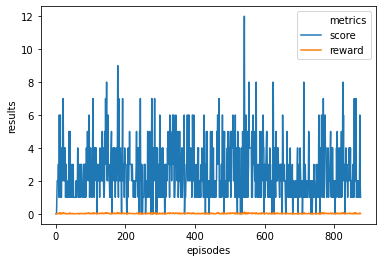

In [24]:
N0 = 1
gamma = 1
Lambda = 0.7
run_experiment(N0, gamma, Lambda)

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 1
Game 4      Score: 2
Game 5      Score: 2
Game 6      Score: 2
Game 7      Score: 3
Game 8      Score: 3
Game 9      Score: 1
Game 10      Score: 6
Game 11      Score: 2
Game 12      Score: 2
Game 13      Score: 6
Game 14      Score: 1
Game 15      Score: 4
Game 16      Score: 1
Game 17      Score: 3
Game 18      Score: 2
Game 19      Score: 4
Game 20      Score: 3
Game 21      Score: 7
Game 22      Score: 4
Game 23      Score: 2
Game 24      Score: 4
Game 25      Score: 3
Game 26      Score: 2
Game 27      Score: 4
Game 28      Score: 1
Game 29      Score: 3
Game 30      Score: 3
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 2
Game 38      Score: 5
Game 39      Score: 1
Game 40      Score: 1
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 3
Game 44      Score: 1
Game 45      Score: 1
Game 46      Score:

Game 364      Score: 1
Game 365      Score: 2
Game 366      Score: 4
Game 367      Score: 3
Game 368      Score: 3
Game 369      Score: 6
Game 370      Score: 0
Game 371      Score: 1
Game 372      Score: 1
Game 373      Score: 1
Game 374      Score: 2
Game 375      Score: 3
Game 376      Score: 3
Game 377      Score: 3
Game 378      Score: 6
Game 379      Score: 2
Game 380      Score: 2
Game 381      Score: 4
Game 382      Score: 6
Game 383      Score: 6
Game 384      Score: 2
Game 385      Score: 2
Game 386      Score: 3
Game 387      Score: 4
Game 388      Score: 4
Game 389      Score: 2
Game 390      Score: 3
Game 391      Score: 1
Game 392      Score: 2
Game 393      Score: 6
Game 394      Score: 4
Game 395      Score: 3
Game 396      Score: 2
Game 397      Score: 6
Game 398      Score: 3
Game 399      Score: 1
Game 400      Score: 1
Game 401      Score: 1
Game 402      Score: 1
Game 403      Score: 3
Game 404      Score: 2
Game 405      Score: 2
Game 406      Score: 1
Game 407   

Game 725      Score: 2
Game 726      Score: 2
Game 727      Score: 5
Game 728      Score: 4
Game 729      Score: 1
Game 730      Score: 1
Game 731      Score: 2
Game 732      Score: 1
Game 733      Score: 2
Game 734      Score: 0
Game 735      Score: 2
Game 736      Score: 2
Game 737      Score: 0
Game 738      Score: 1
Game 739      Score: 2
Game 740      Score: 1
Game 741      Score: 1
Game 742      Score: 3
Game 743      Score: 2
Game 744      Score: 2
Game 745      Score: 1
Game 746      Score: 1
Game 747      Score: 1
Game 748      Score: 0
Game 749      Score: 3
Game 750      Score: 2
Game 751      Score: 2
Game 752      Score: 1
Game 753      Score: 2
Game 754      Score: 3
Game 755      Score: 1
Game 756      Score: 6
Game 757      Score: 1
Game 758      Score: 3
Game 759      Score: 1
Game 760      Score: 0
Game 761      Score: 4
Game 762      Score: 1
Game 763      Score: 2
Game 764      Score: 6
Game 765      Score: 2
Game 766      Score: 4
Game 767      Score: 3
Game 768   

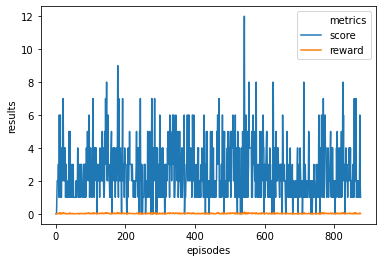

In [23]:
N0 = 1
gamma = 1
Lambda = 1
run_experiment(N0, gamma, Lambda)

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 1
Game 4      Score: 3
Game 5      Score: 1
Game 6      Score: 3
Game 7      Score: 1
Game 8      Score: 1
Game 9      Score: 4
Game 10      Score: 3
Game 11      Score: 3
Game 12      Score: 2
Game 13      Score: 3
Game 14      Score: 4
Game 15      Score: 5
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 2
Game 19      Score: 0
Game 20      Score: 1
Game 21      Score: 4
Game 22      Score: 1
Game 23      Score: 4
Game 24      Score: 1
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 2
Game 28      Score: 2
Game 29      Score: 4
Game 30      Score: 5
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 2
Game 38      Score: 2
Game 39      Score: 3
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 1
Game 43      Score: 1
Game 44      Score: 2
Game 45      Score: 3
Game 46      Score:

Game 363      Score: 2
Game 364      Score: 4
Game 365      Score: 2
Game 366      Score: 1
Game 367      Score: 3
Game 368      Score: 2
Game 369      Score: 4
Game 370      Score: 1
Game 371      Score: 3
Game 372      Score: 5
Game 373      Score: 2
Game 374      Score: 2
Game 375      Score: 1
Game 376      Score: 5
Game 377      Score: 3
Game 378      Score: 1
Game 379      Score: 3
Game 380      Score: 3
Game 381      Score: 3
Game 382      Score: 4
Game 383      Score: 3
Game 384      Score: 3
Game 385      Score: 3
Game 386      Score: 2
Game 387      Score: 12
Game 388      Score: 3
Game 389      Score: 3
Game 390      Score: 1
Game 391      Score: 5
Game 392      Score: 4
Game 393      Score: 3
Game 394      Score: 5
Game 395      Score: 2
Game 396      Score: 3
Game 397      Score: 3
Game 398      Score: 5
Game 399      Score: 3
Game 400      Score: 4
Game 401      Score: 2
Game 402      Score: 3
Game 403      Score: 1
Game 404      Score: 2
Game 405      Score: 3
Game 406  

Game 725      Score: 1
Game 726      Score: 3
Game 727      Score: 5
Game 728      Score: 4
Game 729      Score: 1
Game 730      Score: 7
Game 731      Score: 5
Game 732      Score: 7
Game 733      Score: 3
Game 734      Score: 3
Game 735      Score: 6
Game 736      Score: 4
Game 737      Score: 4
Game 738      Score: 2
Game 739      Score: 1
Game 740      Score: 1
Game 741      Score: 4
Game 742      Score: 5
Game 743      Score: 3
Game 744      Score: 1
Game 745      Score: 4
Game 746      Score: 8
Game 747      Score: 4
Game 748      Score: 1
Game 749      Score: 3
Game 750      Score: 6
Game 751      Score: 3
Game 752      Score: 7
Game 753      Score: 2
Game 754      Score: 4
Game 755      Score: 2
Game 756      Score: 7
Game 757      Score: 1
Game 758      Score: 4
Game 759      Score: 5
Game 760      Score: 3
Game 761      Score: 5
Game 762      Score: 5
Game 763      Score: 1
Game 764      Score: 2
Game 765      Score: 3
Game 766      Score: 3
Game 767      Score: 3
Game 768   

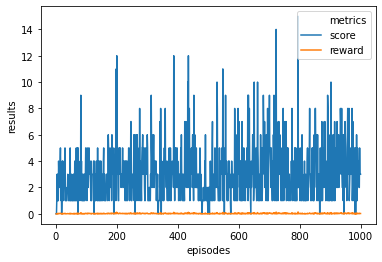

In [22]:
N0 = 1
gamma = 0.99
Lambda = 0
run_experiment(N0, gamma, Lambda)

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 1
Game 4      Score: 3
Game 5      Score: 1
Game 6      Score: 3
Game 7      Score: 1
Game 8      Score: 1
Game 9      Score: 4
Game 10      Score: 3
Game 11      Score: 3
Game 12      Score: 2
Game 13      Score: 3
Game 14      Score: 4
Game 15      Score: 5
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 2
Game 19      Score: 0
Game 20      Score: 1
Game 21      Score: 4
Game 22      Score: 1
Game 23      Score: 4
Game 24      Score: 1
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 2
Game 28      Score: 2
Game 29      Score: 4
Game 30      Score: 5
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 2
Game 38      Score: 2
Game 39      Score: 3
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 1
Game 43      Score: 1
Game 44      Score: 2
Game 45      Score: 3
Game 46      Score:

Game 363      Score: 2
Game 364      Score: 4
Game 365      Score: 2
Game 366      Score: 1
Game 367      Score: 3
Game 368      Score: 2
Game 369      Score: 4
Game 370      Score: 1
Game 371      Score: 3
Game 372      Score: 5
Game 373      Score: 2
Game 374      Score: 2
Game 375      Score: 1
Game 376      Score: 5
Game 377      Score: 3
Game 378      Score: 1
Game 379      Score: 3
Game 380      Score: 3
Game 381      Score: 3
Game 382      Score: 4
Game 383      Score: 3
Game 384      Score: 3
Game 385      Score: 3
Game 386      Score: 2
Game 387      Score: 12
Game 388      Score: 3
Game 389      Score: 3
Game 390      Score: 1
Game 391      Score: 5
Game 392      Score: 4
Game 393      Score: 3
Game 394      Score: 5
Game 395      Score: 2
Game 396      Score: 3
Game 397      Score: 3
Game 398      Score: 5
Game 399      Score: 3
Game 400      Score: 4
Game 401      Score: 2
Game 402      Score: 3
Game 403      Score: 1
Game 404      Score: 2
Game 405      Score: 3
Game 406  

Game 720      Score: 3
Game 721      Score: 5
Game 722      Score: 1
Game 723      Score: 14
Game 724      Score: 4
Game 725      Score: 1
Game 726      Score: 3
Game 727      Score: 5
Game 728      Score: 4
Game 729      Score: 1
Game 730      Score: 7
Game 731      Score: 5
Game 732      Score: 7
Game 733      Score: 3
Game 734      Score: 3
Game 735      Score: 6
Game 736      Score: 4
Game 737      Score: 4
Game 738      Score: 2
Game 739      Score: 1
Game 740      Score: 1
Game 741      Score: 4
Game 742      Score: 5
Game 743      Score: 3
Game 744      Score: 1
Game 745      Score: 4
Game 746      Score: 8
Game 747      Score: 4
Game 748      Score: 1
Game 749      Score: 3
Game 750      Score: 6
Game 751      Score: 3
Game 752      Score: 7
Game 753      Score: 2
Game 754      Score: 4
Game 755      Score: 2
Game 756      Score: 7
Game 757      Score: 1
Game 758      Score: 4
Game 759      Score: 5
Game 760      Score: 3
Game 761      Score: 5
Game 762      Score: 5
Game 763  

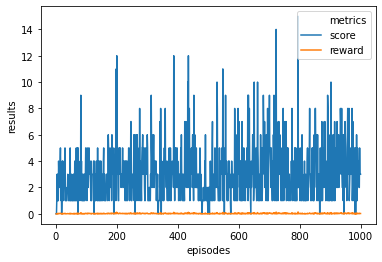

In [13]:
N0 = 1
gamma = 0.99
Lambda = 0.2
run_experiment(N0, gamma, Lambda)

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 1
Game 4      Score: 3
Game 5      Score: 1
Game 6      Score: 3
Game 7      Score: 1
Game 8      Score: 1
Game 9      Score: 4
Game 10      Score: 3
Game 11      Score: 3
Game 12      Score: 2
Game 13      Score: 3
Game 14      Score: 4
Game 15      Score: 5
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 2
Game 19      Score: 0
Game 20      Score: 1
Game 21      Score: 4
Game 22      Score: 1
Game 23      Score: 4
Game 24      Score: 1
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 2
Game 28      Score: 2
Game 29      Score: 4
Game 30      Score: 5
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 2
Game 38      Score: 2
Game 39      Score: 3
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 1
Game 43      Score: 1
Game 44      Score: 2
Game 45      Score: 3
Game 46      Score:

Game 363      Score: 2
Game 364      Score: 4
Game 365      Score: 2
Game 366      Score: 1
Game 367      Score: 3
Game 368      Score: 2
Game 369      Score: 4
Game 370      Score: 1
Game 371      Score: 3
Game 372      Score: 5
Game 373      Score: 2
Game 374      Score: 2
Game 375      Score: 1
Game 376      Score: 5
Game 377      Score: 3
Game 378      Score: 1
Game 379      Score: 3
Game 380      Score: 3
Game 381      Score: 3
Game 382      Score: 4
Game 383      Score: 3
Game 384      Score: 3
Game 385      Score: 3
Game 386      Score: 2
Game 387      Score: 12
Game 388      Score: 3
Game 389      Score: 3
Game 390      Score: 1
Game 391      Score: 5
Game 392      Score: 4
Game 393      Score: 3
Game 394      Score: 5
Game 395      Score: 2
Game 396      Score: 3
Game 397      Score: 3
Game 398      Score: 5
Game 399      Score: 3
Game 400      Score: 4
Game 401      Score: 2
Game 402      Score: 3
Game 403      Score: 1
Game 404      Score: 2
Game 405      Score: 3
Game 406  

Game 727      Score: 5
Game 728      Score: 4
Game 729      Score: 1
Game 730      Score: 7
Game 731      Score: 5
Game 732      Score: 7
Game 733      Score: 3
Game 734      Score: 3
Game 735      Score: 6
Game 736      Score: 4
Game 737      Score: 4
Game 738      Score: 2
Game 739      Score: 1
Game 740      Score: 1
Game 741      Score: 4
Game 742      Score: 5
Game 743      Score: 3
Game 744      Score: 1
Game 745      Score: 4
Game 746      Score: 8
Game 747      Score: 4
Game 748      Score: 1
Game 749      Score: 3
Game 750      Score: 6
Game 751      Score: 3
Game 752      Score: 7
Game 753      Score: 2
Game 754      Score: 4
Game 755      Score: 2
Game 756      Score: 7
Game 757      Score: 1
Game 758      Score: 4
Game 759      Score: 5
Game 760      Score: 3
Game 761      Score: 5
Game 762      Score: 5
Game 763      Score: 1
Game 764      Score: 2
Game 765      Score: 3
Game 766      Score: 3
Game 767      Score: 3
Game 768      Score: 1
Game 769      Score: 1
Game 770   

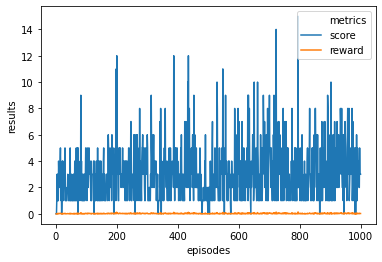

In [14]:
N0 = 1
gamma = 0.99
Lambda = 0.5
run_experiment(N0, gamma, Lambda)

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 1
Game 4      Score: 3
Game 5      Score: 1
Game 6      Score: 3
Game 7      Score: 1
Game 8      Score: 1
Game 9      Score: 4
Game 10      Score: 3
Game 11      Score: 3
Game 12      Score: 2
Game 13      Score: 3
Game 14      Score: 4
Game 15      Score: 5
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 2
Game 19      Score: 0
Game 20      Score: 1
Game 21      Score: 4
Game 22      Score: 1
Game 23      Score: 4
Game 24      Score: 1
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 2
Game 28      Score: 2
Game 29      Score: 4
Game 30      Score: 5
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 2
Game 38      Score: 2
Game 39      Score: 3
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 1
Game 43      Score: 1
Game 44      Score: 2
Game 45      Score: 3
Game 46      Score:

Game 363      Score: 2
Game 364      Score: 4
Game 365      Score: 2
Game 366      Score: 1
Game 367      Score: 3
Game 368      Score: 2
Game 369      Score: 4
Game 370      Score: 1
Game 371      Score: 3
Game 372      Score: 5
Game 373      Score: 2
Game 374      Score: 2
Game 375      Score: 1
Game 376      Score: 5
Game 377      Score: 3
Game 378      Score: 1
Game 379      Score: 3
Game 380      Score: 3
Game 381      Score: 3
Game 382      Score: 4
Game 383      Score: 3
Game 384      Score: 3
Game 385      Score: 3
Game 386      Score: 2
Game 387      Score: 12
Game 388      Score: 3
Game 389      Score: 3
Game 390      Score: 1
Game 391      Score: 5
Game 392      Score: 4
Game 393      Score: 3
Game 394      Score: 5
Game 395      Score: 2
Game 396      Score: 3
Game 397      Score: 3
Game 398      Score: 5
Game 399      Score: 3
Game 400      Score: 4
Game 401      Score: 2
Game 402      Score: 3
Game 403      Score: 1
Game 404      Score: 2
Game 405      Score: 3
Game 406  

Game 724      Score: 4
Game 725      Score: 1
Game 726      Score: 3
Game 727      Score: 5
Game 728      Score: 4
Game 729      Score: 1
Game 730      Score: 7
Game 731      Score: 5
Game 732      Score: 7
Game 733      Score: 3
Game 734      Score: 3
Game 735      Score: 6
Game 736      Score: 4
Game 737      Score: 4
Game 738      Score: 2
Game 739      Score: 1
Game 740      Score: 1
Game 741      Score: 4
Game 742      Score: 5
Game 743      Score: 3
Game 744      Score: 1
Game 745      Score: 4
Game 746      Score: 8
Game 747      Score: 4
Game 748      Score: 1
Game 749      Score: 3
Game 750      Score: 6
Game 751      Score: 3
Game 752      Score: 7
Game 753      Score: 2
Game 754      Score: 4
Game 755      Score: 2
Game 756      Score: 7
Game 757      Score: 1
Game 758      Score: 4
Game 759      Score: 5
Game 760      Score: 3
Game 761      Score: 5
Game 762      Score: 5
Game 763      Score: 1
Game 764      Score: 2
Game 765      Score: 3
Game 766      Score: 3
Game 767   

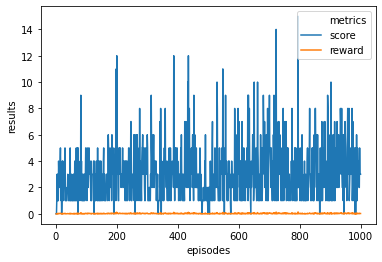

In [15]:
N0 = 1
gamma = 0.99
Lambda = 0.7
run_experiment(N0, gamma, Lambda)

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 1
Game 4      Score: 3
Game 5      Score: 1
Game 6      Score: 3
Game 7      Score: 1
Game 8      Score: 1
Game 9      Score: 4
Game 10      Score: 3
Game 11      Score: 3
Game 12      Score: 2
Game 13      Score: 3
Game 14      Score: 4
Game 15      Score: 5
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 2
Game 19      Score: 0
Game 20      Score: 1
Game 21      Score: 4
Game 22      Score: 1
Game 23      Score: 4
Game 24      Score: 1
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 2
Game 28      Score: 2
Game 29      Score: 4
Game 30      Score: 5
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 2
Game 38      Score: 2
Game 39      Score: 3
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 1
Game 43      Score: 1
Game 44      Score: 2
Game 45      Score: 3
Game 46      Score:

Game 363      Score: 2
Game 364      Score: 4
Game 365      Score: 2
Game 366      Score: 1
Game 367      Score: 3
Game 368      Score: 2
Game 369      Score: 4
Game 370      Score: 1
Game 371      Score: 3
Game 372      Score: 5
Game 373      Score: 2
Game 374      Score: 2
Game 375      Score: 1
Game 376      Score: 5
Game 377      Score: 3
Game 378      Score: 1
Game 379      Score: 3
Game 380      Score: 3
Game 381      Score: 3
Game 382      Score: 4
Game 383      Score: 3
Game 384      Score: 3
Game 385      Score: 3
Game 386      Score: 2
Game 387      Score: 12
Game 388      Score: 3
Game 389      Score: 3
Game 390      Score: 1
Game 391      Score: 5
Game 392      Score: 4
Game 393      Score: 3
Game 394      Score: 5
Game 395      Score: 2
Game 396      Score: 3
Game 397      Score: 3
Game 398      Score: 5
Game 399      Score: 3
Game 400      Score: 4
Game 401      Score: 2
Game 402      Score: 3
Game 403      Score: 1
Game 404      Score: 2
Game 405      Score: 3
Game 406  

Game 724      Score: 4
Game 725      Score: 1
Game 726      Score: 3
Game 727      Score: 5
Game 728      Score: 4
Game 729      Score: 1
Game 730      Score: 7
Game 731      Score: 5
Game 732      Score: 7
Game 733      Score: 3
Game 734      Score: 3
Game 735      Score: 6
Game 736      Score: 4
Game 737      Score: 4
Game 738      Score: 2
Game 739      Score: 1
Game 740      Score: 1
Game 741      Score: 4
Game 742      Score: 5
Game 743      Score: 3
Game 744      Score: 1
Game 745      Score: 4
Game 746      Score: 8
Game 747      Score: 4
Game 748      Score: 1
Game 749      Score: 3
Game 750      Score: 6
Game 751      Score: 3
Game 752      Score: 7
Game 753      Score: 2
Game 754      Score: 4
Game 755      Score: 2
Game 756      Score: 7
Game 757      Score: 1
Game 758      Score: 4
Game 759      Score: 5
Game 760      Score: 3
Game 761      Score: 5
Game 762      Score: 5
Game 763      Score: 1
Game 764      Score: 2
Game 765      Score: 3
Game 766      Score: 3
Game 767   

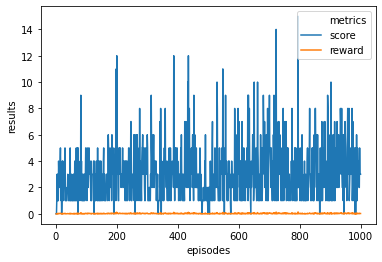

In [16]:
N0 = 1
gamma = 0.99
Lambda = 1
run_experiment(N0, gamma, Lambda)

Game 1      Score: 3
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 0
Game 6      Score: 2
Game 7      Score: 3
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 2
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 1
Game 25      Score: 1
Game 26      Score: 0
Game 27      Score: 2
Game 28      Score: 3
Game 29      Score: 1
Game 30      Score: 3
Game 31      Score: 2
Game 32      Score: 0
Game 33      Score: 1
Game 34      Score: 3
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 1
Game 38      Score: 2
Game 39      Score: 1
Game 40      Score: 0
Game 41      Score: 0
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 373      Score: 3
Game 374      Score: 8
Game 375      Score: 4
Game 376      Score: 9
Game 377      Score: 4
Game 378      Score: 2
Game 379      Score: 8
Game 380      Score: 5
Game 381      Score: 7
Game 382      Score: 4
Game 383      Score: 2
Game 384      Score: 3
Game 385      Score: 9
Game 386      Score: 4
Game 387      Score: 2
Game 388      Score: 5
Game 389      Score: 4
Game 390      Score: 2
Game 391      Score: 6
Game 392      Score: 4
Game 393      Score: 5
Game 394      Score: 10
Game 395      Score: 2
Game 396      Score: 4
Game 397      Score: 4
Game 398      Score: 5
Game 399      Score: 4
Game 400      Score: 7
Game 401      Score: 2
Game 402      Score: 4
Game 403      Score: 4
Game 404      Score: 4
Game 405      Score: 4
Game 406      Score: 4
Game 407      Score: 4
Game 408      Score: 6
Game 409      Score: 6
Game 410      Score: 2
Game 411      Score: 4
Game 412      Score: 1
Game 413      Score: 1
Game 414      Score: 2
Game 415      Score: 1
Game 416  

Game 730      Score: 0
Game 731      Score: 0
Game 732      Score: 0
Game 733      Score: 0
Game 734      Score: 2
Game 735      Score: 2
Game 736      Score: 4
Game 737      Score: 8
Game 738      Score: 10
Game 739      Score: 1
Game 740      Score: 4
Game 741      Score: 1
Game 742      Score: 1
Game 743      Score: 1
Game 744      Score: 1
Game 745      Score: 1
Game 746      Score: 0
Game 747      Score: 2
Game 748      Score: 0
Game 749      Score: 3
Game 750      Score: 2
Game 751      Score: 5
Game 752      Score: 0
Game 753      Score: 3
Game 754      Score: 3
Game 755      Score: 3
Game 756      Score: 4
Game 757      Score: 2
Game 758      Score: 4
Game 759      Score: 3
Game 760      Score: 3
Game 761      Score: 3
Game 762      Score: 3
Game 763      Score: 3
Game 764      Score: 0
Game 765      Score: 0
Game 766      Score: 3
Game 767      Score: 6
Game 768      Score: 7
Game 769      Score: 3
Game 770      Score: 1
Game 771      Score: 1
Game 772      Score: 0
Game 773  

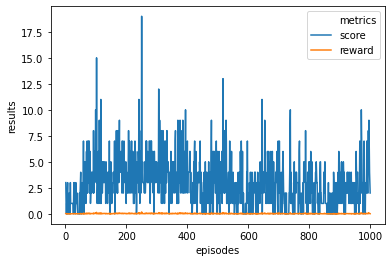

In [17]:
N0 = 1
gamma = 0.5
Lambda = 0
run_experiment(N0, gamma, Lambda)

Game 1      Score: 3
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 0
Game 6      Score: 2
Game 7      Score: 3
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 2
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 1
Game 25      Score: 1
Game 26      Score: 0
Game 27      Score: 2
Game 28      Score: 3
Game 29      Score: 1
Game 30      Score: 3
Game 31      Score: 2
Game 32      Score: 0
Game 33      Score: 1
Game 34      Score: 3
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 1
Game 38      Score: 2
Game 39      Score: 1
Game 40      Score: 0
Game 41      Score: 0
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 373      Score: 3
Game 374      Score: 8
Game 375      Score: 4
Game 376      Score: 9
Game 377      Score: 4
Game 378      Score: 2
Game 379      Score: 8
Game 380      Score: 5
Game 381      Score: 7
Game 382      Score: 4
Game 383      Score: 2
Game 384      Score: 3
Game 385      Score: 9
Game 386      Score: 4
Game 387      Score: 2
Game 388      Score: 5
Game 389      Score: 4
Game 390      Score: 2
Game 391      Score: 6
Game 392      Score: 4
Game 393      Score: 5
Game 394      Score: 10
Game 395      Score: 2
Game 396      Score: 4
Game 397      Score: 4
Game 398      Score: 5
Game 399      Score: 4
Game 400      Score: 7
Game 401      Score: 2
Game 402      Score: 4
Game 403      Score: 4
Game 404      Score: 4
Game 405      Score: 4
Game 406      Score: 4
Game 407      Score: 4
Game 408      Score: 6
Game 409      Score: 6
Game 410      Score: 2
Game 411      Score: 4
Game 412      Score: 1
Game 413      Score: 1
Game 414      Score: 2
Game 415      Score: 1
Game 416  

Game 741      Score: 1
Game 742      Score: 1
Game 743      Score: 1
Game 744      Score: 1
Game 745      Score: 1
Game 746      Score: 0
Game 747      Score: 2
Game 748      Score: 0
Game 749      Score: 3
Game 750      Score: 2
Game 751      Score: 5
Game 752      Score: 0
Game 753      Score: 3
Game 754      Score: 3
Game 755      Score: 3
Game 756      Score: 4
Game 757      Score: 2
Game 758      Score: 4
Game 759      Score: 3
Game 760      Score: 3
Game 761      Score: 3
Game 762      Score: 3
Game 763      Score: 3
Game 764      Score: 0
Game 765      Score: 0
Game 766      Score: 3
Game 767      Score: 6
Game 768      Score: 7
Game 769      Score: 3
Game 770      Score: 1
Game 771      Score: 1
Game 772      Score: 0
Game 773      Score: 0
Game 774      Score: 2
Game 775      Score: 0
Game 776      Score: 0
Game 777      Score: 0
Game 778      Score: 1
Game 779      Score: 2
Game 780      Score: 3
Game 781      Score: 0
Game 782      Score: 5
Game 783      Score: 5
Game 784   

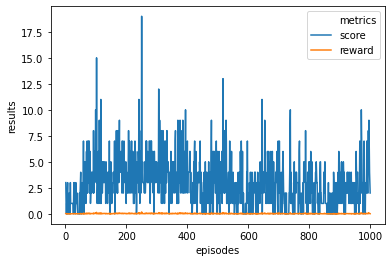

In [18]:
N0 = 1
gamma = 0.5
Lambda = 0.2
run_experiment(N0, gamma, Lambda)

Game 1      Score: 3
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 0
Game 6      Score: 2
Game 7      Score: 3
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 2
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 1
Game 25      Score: 1
Game 26      Score: 0
Game 27      Score: 2
Game 28      Score: 3
Game 29      Score: 1
Game 30      Score: 3
Game 31      Score: 2
Game 32      Score: 0
Game 33      Score: 1
Game 34      Score: 3
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 1
Game 38      Score: 2
Game 39      Score: 1
Game 40      Score: 0
Game 41      Score: 0
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 372      Score: 3
Game 373      Score: 3
Game 374      Score: 8
Game 375      Score: 4
Game 376      Score: 9
Game 377      Score: 4
Game 378      Score: 2
Game 379      Score: 8
Game 380      Score: 5
Game 381      Score: 7
Game 382      Score: 4
Game 383      Score: 2
Game 384      Score: 3
Game 385      Score: 9
Game 386      Score: 4
Game 387      Score: 2
Game 388      Score: 5
Game 389      Score: 4
Game 390      Score: 2
Game 391      Score: 6
Game 392      Score: 4
Game 393      Score: 5
Game 394      Score: 10
Game 395      Score: 2
Game 396      Score: 4
Game 397      Score: 4
Game 398      Score: 5
Game 399      Score: 4
Game 400      Score: 7
Game 401      Score: 2
Game 402      Score: 4
Game 403      Score: 4
Game 404      Score: 4
Game 405      Score: 4
Game 406      Score: 4
Game 407      Score: 4
Game 408      Score: 6
Game 409      Score: 6
Game 410      Score: 2
Game 411      Score: 4
Game 412      Score: 1
Game 413      Score: 1
Game 414      Score: 2
Game 415  

Game 735      Score: 2
Game 736      Score: 4
Game 737      Score: 8
Game 738      Score: 10
Game 739      Score: 1
Game 740      Score: 4
Game 741      Score: 1
Game 742      Score: 1
Game 743      Score: 1
Game 744      Score: 1
Game 745      Score: 1
Game 746      Score: 0
Game 747      Score: 2
Game 748      Score: 0
Game 749      Score: 3
Game 750      Score: 2
Game 751      Score: 5
Game 752      Score: 0
Game 753      Score: 3
Game 754      Score: 3
Game 755      Score: 3
Game 756      Score: 4
Game 757      Score: 2
Game 758      Score: 4
Game 759      Score: 3
Game 760      Score: 3
Game 761      Score: 3
Game 762      Score: 3
Game 763      Score: 3
Game 764      Score: 0
Game 765      Score: 0
Game 766      Score: 3
Game 767      Score: 6
Game 768      Score: 7
Game 769      Score: 3
Game 770      Score: 1
Game 771      Score: 1
Game 772      Score: 0
Game 773      Score: 0
Game 774      Score: 2
Game 775      Score: 0
Game 776      Score: 0
Game 777      Score: 0
Game 778  

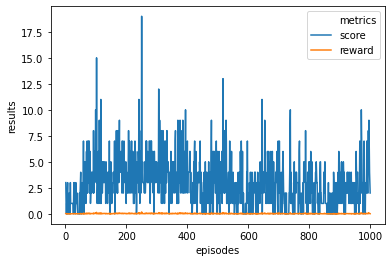

In [19]:
N0 = 1
gamma = 0.5
Lambda = 0.5
run_experiment(N0, gamma, Lambda)

Game 1      Score: 3
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 0
Game 6      Score: 2
Game 7      Score: 3
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 2
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 1
Game 25      Score: 1
Game 26      Score: 0
Game 27      Score: 2
Game 28      Score: 3
Game 29      Score: 1
Game 30      Score: 3
Game 31      Score: 2
Game 32      Score: 0
Game 33      Score: 1
Game 34      Score: 3
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 1
Game 38      Score: 2
Game 39      Score: 1
Game 40      Score: 0
Game 41      Score: 0
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 362      Score: 3
Game 363      Score: 2
Game 364      Score: 3
Game 365      Score: 4
Game 366      Score: 1
Game 367      Score: 3
Game 368      Score: 1
Game 369      Score: 9
Game 370      Score: 2
Game 371      Score: 1
Game 372      Score: 3
Game 373      Score: 3
Game 374      Score: 8
Game 375      Score: 4
Game 376      Score: 9
Game 377      Score: 4
Game 378      Score: 2
Game 379      Score: 8
Game 380      Score: 5
Game 381      Score: 7
Game 382      Score: 4
Game 383      Score: 2
Game 384      Score: 3
Game 385      Score: 9
Game 386      Score: 4
Game 387      Score: 2
Game 388      Score: 5
Game 389      Score: 4
Game 390      Score: 2
Game 391      Score: 6
Game 392      Score: 4
Game 393      Score: 5
Game 394      Score: 10
Game 395      Score: 2
Game 396      Score: 4
Game 397      Score: 4
Game 398      Score: 5
Game 399      Score: 4
Game 400      Score: 7
Game 401      Score: 2
Game 402      Score: 4
Game 403      Score: 4
Game 404      Score: 4
Game 405  

Game 724      Score: 0
Game 725      Score: 2
Game 726      Score: 0
Game 727      Score: 0
Game 728      Score: 0
Game 729      Score: 0
Game 730      Score: 0
Game 731      Score: 0
Game 732      Score: 0
Game 733      Score: 0
Game 734      Score: 2
Game 735      Score: 2
Game 736      Score: 4
Game 737      Score: 8
Game 738      Score: 10
Game 739      Score: 1
Game 740      Score: 4
Game 741      Score: 1
Game 742      Score: 1
Game 743      Score: 1
Game 744      Score: 1
Game 745      Score: 1
Game 746      Score: 0
Game 747      Score: 2
Game 748      Score: 0
Game 749      Score: 3
Game 750      Score: 2
Game 751      Score: 5
Game 752      Score: 0
Game 753      Score: 3
Game 754      Score: 3
Game 755      Score: 3
Game 756      Score: 4
Game 757      Score: 2
Game 758      Score: 4
Game 759      Score: 3
Game 760      Score: 3
Game 761      Score: 3
Game 762      Score: 3
Game 763      Score: 3
Game 764      Score: 0
Game 765      Score: 0
Game 766      Score: 3
Game 767  

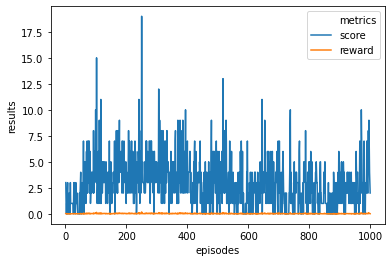

In [20]:
N0 = 1
gamma = 0.5
Lambda = 0.7
run_experiment(N0, gamma, Lambda)

Game 1      Score: 3
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 0
Game 6      Score: 2
Game 7      Score: 3
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 2
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 1
Game 25      Score: 1
Game 26      Score: 0
Game 27      Score: 2
Game 28      Score: 3
Game 29      Score: 1
Game 30      Score: 3
Game 31      Score: 2
Game 32      Score: 0
Game 33      Score: 1
Game 34      Score: 3
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 1
Game 38      Score: 2
Game 39      Score: 1
Game 40      Score: 0
Game 41      Score: 0
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 369      Score: 9
Game 370      Score: 2
Game 371      Score: 1
Game 372      Score: 3
Game 373      Score: 3
Game 374      Score: 8
Game 375      Score: 4
Game 376      Score: 9
Game 377      Score: 4
Game 378      Score: 2
Game 379      Score: 8
Game 380      Score: 5
Game 381      Score: 7
Game 382      Score: 4
Game 383      Score: 2
Game 384      Score: 3
Game 385      Score: 9
Game 386      Score: 4
Game 387      Score: 2
Game 388      Score: 5
Game 389      Score: 4
Game 390      Score: 2
Game 391      Score: 6
Game 392      Score: 4
Game 393      Score: 5
Game 394      Score: 10
Game 395      Score: 2
Game 396      Score: 4
Game 397      Score: 4
Game 398      Score: 5
Game 399      Score: 4
Game 400      Score: 7
Game 401      Score: 2
Game 402      Score: 4
Game 403      Score: 4
Game 404      Score: 4
Game 405      Score: 4
Game 406      Score: 4
Game 407      Score: 4
Game 408      Score: 6
Game 409      Score: 6
Game 410      Score: 2
Game 411      Score: 4
Game 412  

Game 731      Score: 0
Game 732      Score: 0
Game 733      Score: 0
Game 734      Score: 2
Game 735      Score: 2
Game 736      Score: 4
Game 737      Score: 8
Game 738      Score: 10
Game 739      Score: 1
Game 740      Score: 4
Game 741      Score: 1
Game 742      Score: 1
Game 743      Score: 1
Game 744      Score: 1
Game 745      Score: 1
Game 746      Score: 0
Game 747      Score: 2
Game 748      Score: 0
Game 749      Score: 3
Game 750      Score: 2
Game 751      Score: 5
Game 752      Score: 0
Game 753      Score: 3
Game 754      Score: 3
Game 755      Score: 3
Game 756      Score: 4
Game 757      Score: 2
Game 758      Score: 4
Game 759      Score: 3
Game 760      Score: 3
Game 761      Score: 3
Game 762      Score: 3
Game 763      Score: 3
Game 764      Score: 0
Game 765      Score: 0
Game 766      Score: 3
Game 767      Score: 6
Game 768      Score: 7
Game 769      Score: 3
Game 770      Score: 1
Game 771      Score: 1
Game 772      Score: 0
Game 773      Score: 0
Game 774  

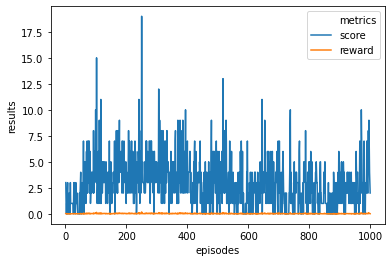

In [21]:
N0 = 1
gamma = 0.5
Lambda = 1
run_experiment(N0, gamma, Lambda)